In [231]:
import pandas as pd 
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
import cv2 as cv
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from preprocessing import *

import numpy as np
import matplotlib.pyplot as plt 
import os
import cv2 as cv
import time

def detect_background_color(image):
    width, height = image.shape[:2]
    corners = [(0, 0), (0, height-1), (width-1, 0), (width-1, height-1)]    
    corners_colors = []
    for corner in corners:
        corners_colors.append(image[corner[0], corner[1]])
    background_color = np.mean(corners_colors, axis=0)
    return background_color


def remove_additive_noise(image, kernal: int): 
    image = cv.filter2D(image, -1, np.ones((kernal, kernal)))
    return image

def remove_implusive_noise(image, kernal: int): 
    image = cv.medianBlur(image, kernal)
    return image

def resize_image(image, width: int, height: int):
    image = cv.resize(image, (width, height))
    return image


def threshold_image(image, threshold: int):
    _, output = cv.threshold(image, 50, 255, cv.THRESH_BINARY)
    return output

def convert_to_binary(image):
    output = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    _, output = cv.threshold(image, 50, 255, cv.THRESH_BINARY)
    output = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    return output

def rotate_45(image):
    angle = 45
    height, width = image.shape[:2]
    background_color = 0 
    background = np.full((height, width, 3), background_color, dtype=np.uint8)
    rotation_matrix = cv.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    rotated_image = cv.warpAffine(image, rotation_matrix, (width, height))
    result = cv.bitwise_and(rotated_image, rotated_image, mask=image)
    return result



def flip_image(image):
    return cv.flip(cv.flip(image, 0), 1)   

def rotate_image(image): 
    return cv.rotate(image, cv.ROTATE_90_COUNTERCLOCKWISE)

def closing(image, height: int, width: int):
    kernal = np.ones((height, width), np.uint8)
    image = cv.morphologyEx(image, cv.MORPH_CLOSE, kernal)
    return image
def openning(image, height: int, width: int):
    kernal = np.ones((height, width), np.uint8)
    image = cv.morphologyEx(image, cv.MORPH_OPEN, kernal)
    return image
def errode(image, height = 1, width = 1, iterations = 1, kernal=None):
    kernal = np.ones((height, width), np.uint8) if kernal is None else kernal
    image = cv.erode(image, kernal, iterations=iterations)
    return image
def dilate(image, height = 1, width = 1, iterations = 1, kernal=None):
    kernal = np.ones((height, width), np.uint8) if kernal is None else kernal
    image = cv.dilate(image, kernal, iterations=iterations)
    return image

def detect_if_flipped(image):
    output = image.copy()
    _, height = image.shape[:2]
    
    output= closing(image, 1, 25)

    output = dilate(output, 1, 15, 2)
    output = errode(output, 1, 90, 4)

    contours, hierarchy = cv.findContours(output, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # for countour in contours:
    #     x, y, w, h = cv.boundingRect(countour)
    #     cv.rectangle(image, (x, y), (x+w, y+h), (255, 255, 0), 2)
    
    # plt.imshow(image, cmap='gray')
    # plt.show()

    rotated = 0
    not_rotated = 0
    padding = 7
    for countour in contours:
        x, y, w, h = cv.boundingRect(countour)
        cropped_image = image[y-padding:y+h+padding, x-padding:x+w+padding]

        # # Calculate the size of each half
        height, width = cropped_image.shape[:2]
        half_height = height // 2

        # # Split the image into two halves
        half1 = cropped_image[:half_height, :]
        half2 = cropped_image[half_height:, :]

        sum1 = np.sum(half1)
        sum2 = np.sum(half2)

        if sum1 < sum2:
            not_rotated += 1
        else: 
            rotated += 1
    
    if rotated > not_rotated:
        return True
    else:
        return False

def detect_if_vertical(image): 
    output = image.copy()
    width, height = image.shape[:2]
    
    output= closing(image, 25, 1)

    output = dilate(output, 15, 1, 1)
    output = errode(output, 15, 1, 2)


    contours, hierarchy = cv.findContours(output, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if contours and len(contours) == 0:
        return False
    
    max_contour = max(contours, key=cv.contourArea)
    x, y, w, h = cv.boundingRect(max_contour)

    aspect_ratio = w/h
  
    if aspect_ratio > 0.1:
        return False
    else :
        return True        

def detect_if_rotated(image):
    output = image.copy()
    width, height = image.shape[:2]
    
    output= closing(image, 1, 25)

    output = dilate(output, 1, 15, 2)
    output = errode(output, 1, 90, 4)
    
    plt.imshow(output, cmap='gray')
    plt.show()
      
    contour, _ = cv.findContours(output, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if len(contour) == 0:
        plt.imshow(image, cmap='gray')
        plt.show()
        return
    max_contour = max(contour, key=cv.contourArea)

    
    x, y, w, h = cv.boundingRect(max_contour)
    contour_area = cv.contourArea(max_contour)
    rect_area = w*h 
    
    
image_size = 500

def preprocess_image(image_file):
    image0 = plt.imread(image_file,0)
    output = image0
    output = convert_to_binary(output)
    output = remove_implusive_noise(output, 5)
    output = resize_image(output, image_size, image_size)
    bg = detect_background_color(output)
    if bg > 127.0:
        output = cv.bitwise_not(output) 

    # for preformace reasons
    vertical = False
    if detect_if_vertical(output):
        vertical = True
        output = rotate_image(output)
    
    if detect_if_flipped(output) and not vertical:
        output = flip_image(output)

    return output



    


In [232]:
data = []

labels = {}

folders = os.listdir()
for i,value in enumerate(folders): 
    if os.path.isdir(value):
        labels[i] = value
        files = os.listdir(value)
        for j in files:
            data.append({'Image': os.path.join(value, j), 'Label': i} )

df = pd.DataFrame(data)

print(labels)

df.head()

{1: 'IBM Plex Sans Arabic preprocessed', 2: 'Lemonada preprocessed', 3: 'Marhey preprocessed', 6: 'Scheherazade New preprocessed'}


,Image,Label
0,IBM Plex Sans Arabic preprocessed\0.jpeg,1
1,IBM Plex Sans Arabic preprocessed\1.jpeg,1
2,IBM Plex Sans Arabic preprocessed\10.jpeg,1
3,IBM Plex Sans Arabic preprocessed\100.jpeg,1
4,IBM Plex Sans Arabic preprocessed\101.jpeg,1


def feature_extraction(path):
    img = skimage.io.imread(path)
    gray = skimage.color.rgb2gray(img)
    gray = util.img_as_ubyte(gray)
    # calculate glcm for gray image 
    glcm = skimage.feature.graycomatrix(gray, [1], [0], 256, symmetric=True, normed=True)

    glcm = np.squeeze(glcm)

    glcm_reshaped = glcm.reshape(-1, 256)

    pca = PCA(n_components=32)

    pca.fit(glcm_reshaped)

    transformed_data = pca.transform(glcm_reshaped)

    transformed_data = transformed_data.T
    pca.fit(transformed_data)
    transformed_data = pca.transform(transformed_data)


    features = transformed_data.flatten()
    return features

In [233]:
# orb = cv.ORB_create()

# def detect_features(path):
#     max_keypoints = 10
#     max_descriptors_per_keypoint = 25
#     image = cv.imread(path, cv.IMREAD_GRAYSCALE)
#     image = cv.resize(image, (256, 256))
#     kp, des = orb.detectAndCompute(image, None)
    
#     # Check if descriptors are found
#     if des is None:
#         return [0] * (max_keypoints * max_descriptors_per_keypoint)  # Return zero descriptors
    
#     if len(kp) > max_keypoints:
#         # Sort keypoints by response and select the top ones
#         sorted_indices = sorted(range(len(kp)), key=lambda i: kp[i].response, reverse=True)
#         selected_indices = sorted_indices[:max_keypoints]
#         kp = [kp[i] for i in selected_indices]
#         des = [des[i] for i in selected_indices]
    
#     # Truncate descriptors if more than max_descriptors_per_keypoint
#     truncated_descriptors = []
#     for d in des:
#         if len(d) > max_descriptors_per_keypoint:
#             truncated_descriptors.append(d[:max_descriptors_per_keypoint])
#         else:
#             truncated_descriptors.append(d)
    
#     # Flatten list of descriptors
#     flattened_descriptors = [item for sublist in truncated_descriptors for item in sublist]
    
#     # Pad with zeros if the number of descriptors is less than required
#     if len(flattened_descriptors) < max_keypoints * max_descriptors_per_keypoint:
#         flattened_descriptors.extend([0] * (max_keypoints * max_descriptors_per_keypoint - len(flattened_descriptors)))
    
#     return flattened_descriptors[:max_keypoints * max_descriptors_per_keypoint]


    
# df['descriptors'] = df['Image'].apply(detect_features)  

# # Expand descriptors into separate columns
# descriptor_columns = ['descriptor_' + str(i) for i in range(250)]  # 3 keypoints with 50 descriptors each
# df_descriptors = pd.DataFrame(df['descriptors'].tolist(), columns=descriptor_columns)

# # Concatenate df with df_descriptors
# df = pd.concat([df, df_descriptors], axis=1)

# # Drop the 'descriptors' column as it's no longer needed
# df = df.drop(columns=['descriptors'])


In [ ]:

def horizontal_profile_projection(image):
    # Compute vertical histogram
    histogram = np.sum(image, axis=1)
    
    # Normalize histogram
    max_value = np.max(histogram)
    normalized_histogram = histogram / max_value
    
    # Compute HPP
    HPP = np.sum(normalized_histogram) / max_value
    
    return HPP


def text_thickness_descriptor(image):
    # Apply edge detection to get the edges
    edges = cv.Canny(image, 50, 150)
    
    # Apply morphological operations to get the skeleton
    kernel = np.ones((3,3), np.uint8)
    skeleton = cv.morphologyEx(edges, cv.MORPH_SKELETON, kernel)
    
    # Calculate distance transform
    distance_transform = cv.distanceTransform(skeleton, cv.DIST_L2, 3)
    
    # Normalize distance transform
    distance_transform_normalized = cv.normalize(distance_transform, None, 0, 255, cv.NORM_MINMAX, cv.CV_8UC1)
    
    # Return the normalized distance transform
    return distance_transform_normalized

def edge_orientation(image, x, y):
    sobel_x = cv.Sobel(image, cv.CV_64F, 1, 0, ksize=3)  # Horizontal gradient
    sobel_y = cv.Sobel(image, cv.CV_64F, 0, 1, ksize=3)  # Vertical gradient
    orientation = np.arctan2(sobel_y[y, x], sobel_x[y, x])
    return np.rad2deg(orientation)  # Convert to degrees

def text_orientation(image):
    # Preprocessing
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    gray = cv.GaussianBlur(gray, (5, 5), 0)

    # Edge detection
    edges = cv.Canny(gray, 50, 150)

    # Skeletonization
    skeleton = cv.ximgproc.thinning(gray, cv.THRESH_BINARY | cv.THRESH_OTSU)

    # Orientation estimation
    toe_hist, toe_bins = np.histogram(
        [edge_orientation(edges, x, y) for y, row in enumerate(edges) for x, _ in enumerate(row) if edges[y, x] > 0],
        bins=np.arange(-90, 90.1, step=1)  # Adjust bin range and step size as needed
    )
    tos_hist, tos_bins = np.histogram(
        # Implement skeleton orientation calculation here
    )

In [234]:

def precompute_gabor_kernels(ksize, sigma, lambd, gamma, psi):
    gabor_kernels = {}
    for theta in [0]:
        for freq in lambd:
            gabor_kernel = cv.getGaborKernel((ksize, ksize), sigma, theta, freq, gamma, psi)
            gabor_kernels[(theta, freq)] = gabor_kernel
    return gabor_kernels


def feature_extraction(img_path):
    ksize = 31
    sigma = 2
    lambd = [0.3, 4]
    gamma = 0.5
    psi = 0

    # Precompute Gabor Kernels
    # gabor_kernels = precompute_gabor_kernels(ksize, sigma, lambd, gamma, psi)

    # Read and preprocess image
    image = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    
    
    
    # image = cv.resize(image, (256, 256))
    # _, image = cv.threshold(image, 127, 255, cv.THRESH_BINARY)
    # image = preprocess_image(img_path,256)
    
    
    features = []
    # for gabor_kernel in gabor_kernels.values():
    #     # Apply Gabor filter
    #     filtered_image = cv.filter2D(image, cv.CV_64F, gabor_kernel)

    #     # Calculate mean and standard deviation using numpy operations
    #     mean_val = np.mean(filtered_image)
    #     std_val = np.std(filtered_image)

    #     # Append to features
    #     features.extend([mean_val, std_val])
        
    
    # radius = 2
    # n_points = 8 * radius
    # lbp_img = local_binary_pattern(image, n_points, radius, method='default')
    # mean_val = np.mean(lbp_img)
    # std_val = np.std(lbp_img)
    # features.extend([mean_val, std_val])
    
    dft = cv.dft(np.float32(image), flags=cv.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    # magnitude_spectrum = cv.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1])
    
    # min_freq = np.min(dft_shift)
    # max_freq = np.max(dft_shift)
     
    # Define passband cutoff frequencies
    passband_lower_cutoff = [0, 36, 72, 108, 144, 180, 216]
    passband_upper_cutoff = [41, 77, 113, 149, 185, 221, 255]
    
    # passband_lower_cutoff = np.linspace(min_freq, max_freq, 11)[1:9] # Exclude the last value
    # passband_upper_cutoff = np.linspace(min_freq, max_freq, 11)[2:-1]   # Exclude the first value
    # passband_lower_cutoff = passband_lower_cutoff.tolist()
    # passband_upper_cutoff = passband_upper_cutoff.tolist()

    
    # Create a passband filter in the frequency domain
    rows, cols = dft_shift.shape[0], dft_shift.shape[1]
    crow, ccol = rows // 2, cols // 2
    

 
    for i,lower_cutoff in enumerate(passband_lower_cutoff):
        mask = np.zeros((rows, cols, 2), np.uint8)
        mask[crow - int(passband_upper_cutoff[i]):crow + int(passband_upper_cutoff[i]), 
            ccol - int(passband_upper_cutoff[i]):ccol + int(passband_upper_cutoff[i])] = 1
        mask[crow - int(passband_lower_cutoff[i]):crow + int(passband_lower_cutoff[i]), 
            ccol - int(passband_lower_cutoff[i]):ccol + int(passband_lower_cutoff[i])] = 0  
        filtered_dft = dft_shift * mask
        magnitude_spectrum = 20 * np.log(cv.magnitude(filtered_dft[:, :, 0], filtered_dft[:, :, 1]) + 1e-10)
        mean = np.mean(magnitude_spectrum)
        std = np.std(magnitude_spectrum)
        features.extend([mean, std])

    return features


x = pd.DataFrame(df['Image'].apply(feature_extraction))
x.head()


,Image
0,"[0.0029918927068439587, 6.470000871639764, 0.1..."
1,"[0.08371658307982749, 96.9201213316705, 3.8879..."
2,"[0.08810632340335747, 79.82152194462884, 4.091..."
3,"[0.07063845379335282, 16.834082516010522, 3.28..."
4,"[0.22153699474163047, 194.63653957085154, 10.2..."


In [235]:
# def extract_features_sepctral(image_path):
#     image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
#     image = cv.resize(image, (256, 256))
#     dft = cv.dft(np.float32(image), flags=cv.DFT_COMPLEX_OUTPUT)
#     # dft_shift = np.fft.fftshift(dft)
#     # magnitude_spectrum = cv.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1])
    
    
#     # Define passband cutoff frequencies
#     passband_lower_cutoff = [0 , 64 , 128, 192]  # Lower cutoff frequency of the passband
#     passband_upper_cutoff = [64, 128, 192 ,256]  # Upper cutoff frequency of the passband

#     # Create a passband filter in the frequency domain
#     rows, cols = image.shape
#     crow, ccol = rows // 2, cols // 2
    

#     features = []
#     for i,lower_cutoff in enumerate(passband_lower_cutoff):
#         mask = np.zeros((rows, cols, 2), np.uint8)
#         mask[crow - passband_upper_cutoff[i]:crow + passband_upper_cutoff[i], 
#             ccol - passband_upper_cutoff[i]:ccol + passband_upper_cutoff[i]] = 1
#         mask[crow - passband_lower_cutoff[i]:crow + passband_lower_cutoff[i], 
#             ccol - passband_lower_cutoff[i]:ccol + passband_lower_cutoff[i]] = 0  
#         filtered_dft = dft * mask
#         magnitude_spectrum = 20 * np.log(cv.magnitude(filtered_dft[:, :, 0], filtered_dft[:, :, 1]) + 1e-10)
#         mean = np.mean(magnitude_spectrum)
#         std = np.std(magnitude_spectrum)
#         features.extend([mean, std])
        
        
#     return features
        
#     # magnitude_spectrum = 20 * np.log(cv.magnitude(dft[:, :, 0], dft[:, :, 1]))
#     # print(magnitude_spectrum)
#     # print(magnitude_spectrum.shape)
#     # mean = np.mean(magnitude_spectrum)
#     # std = np.std(magnitude_spectrum)
    
    
    
# x = pd.DataFrame(df['Image'].apply(extract_features_sepctral))
# x.head()
# # extract_features_sepctral('C:\\Users\\Mohamad Ameen\\Desktop\\NN-Project\\fonts-dataset\\IBM Plex Sans Arabic\\0.jpeg')

In [236]:
# orb = cv.ORB_create()

# def detect_features(path):
#     max_keypoints = 10
#     max_descriptors_per_keypoint = 25
#     image = cv.imread(path, cv.IMREAD_GRAYSCALE)
#     image = cv.resize(image, (256, 256))
#     kp, des = orb.detectAndCompute(image, None)
    
#     # Check if descriptors are found
#     if des is None:
#         return [0] * (max_keypoints * max_descriptors_per_keypoint)  # Return zero descriptors
    
#     if len(kp) > max_keypoints:
#         # Sort keypoints by response and select the top ones
#         sorted_indices = sorted(range(len(kp)), key=lambda i: kp[i].response, reverse=True)
#         selected_indices = sorted_indices[:max_keypoints]
#         kp = [kp[i] for i in selected_indices]
#         des = [des[i] for i in selected_indices]
    
#     # Truncate descriptors if more than max_descriptors_per_keypoint
#     truncated_descriptors = []
#     for d in des:
#         if len(d) > max_descriptors_per_keypoint:
#             truncated_descriptors.append(d[:max_descriptors_per_keypoint])
#         else:
#             truncated_descriptors.append(d)
    
#     # Flatten list of descriptors
#     flattened_descriptors = [item for sublist in truncated_descriptors for item in sublist]
    
#     # Pad with zeros if the number of descriptors is less than required
#     if len(flattened_descriptors) < max_keypoints * max_descriptors_per_keypoint:
#         flattened_descriptors.extend([0] * (max_keypoints * max_descriptors_per_keypoint - len(flattened_descriptors)))
    
#     return flattened_descriptors[:max_keypoints * max_descriptors_per_keypoint]


    
# df['descriptors'] = df['Image'].apply(detect_features)  

# # Expand descriptors into separate columns
# descriptor_columns = ['descriptor_' + str(i) for i in range(250)]  # 3 keypoints with 50 descriptors each
# df_descriptors = pd.DataFrame(df['descriptors'].tolist(), columns=descriptor_columns)

# # Concatenate df with df_descriptors
# df = pd.concat([df, df_descriptors], axis=1)

# # Drop the 'descriptors' column as it's no longer needed
# df = df.drop(columns=['descriptors'])


In [237]:
x = pd.DataFrame(x['Image'].to_list(), columns=['Feature'+str(i) for i in range(1, len(x['Image'][0])+1)])
df = pd.concat([df, x], axis=1) 

In [238]:
df.drop('Image', axis=1, inplace=True)
df.head()



# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(df.drop(columns=['Label']))
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_scaled)



,Label,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14,Feature15,Feature16,Feature17,Feature18
0,1,0.002992,6.470001,0.138948,10.193403,-398.807526,182.564346,-294.638977,264.294098,-197.172577,283.840729,-456.820831,44.968208,-435.102600,116.210236,-408.761078,163.923767,-385.671295,195.510330
1,1,0.083717,96.920121,3.887910,144.298718,-393.994904,196.791565,-280.580383,286.667786,-173.433411,309.367554,-456.416626,49.887211,-432.538177,127.929474,-404.228119,178.271729,-379.669373,211.167328
2,1,0.088106,79.821522,4.091776,125.082863,-394.186005,196.224625,-281.657837,284.957489,-174.532516,308.182922,-456.459900,49.358196,-432.767700,126.882439,-404.434784,177.613449,-379.927979,210.486694
3,1,0.070638,16.834083,3.280544,27.453099,-396.864380,188.310486,-289.317200,272.778687,-188.673889,292.984650,-456.692261,46.534142,-434.249329,120.111336,-407.051819,169.335541,-383.286011,201.733810
4,1,0.221537,194.636540,10.288475,340.988318,-392.632446,200.822937,-278.428589,290.124481,-171.997452,310.917694,-456.362701,50.540901,-432.338562,128.840347,-403.821472,179.562866,-378.617371,213.942200


In [239]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["Label"]), df['Label'], test_size=0.2, random_state=42)

In [240]:
# df_features = pd.DataFrame(X_train['features'].to_list(), columns=[f'feature_{i+1}' for i in range(1024)])

# df_features_test = pd.DataFrame(X_test['features'].to_list(), columns=[f'feature_{i+1}' for i in range(1024)])

In [241]:
X = df.drop(columns=['Label'])
y= df['Label']
clf = RandomForestClassifier(n_estimators=1000, random_state=42 , n_jobs=-1)

# Train the classifier on the training data
clf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

In [242]:
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7525


### Cross validation on the test-set

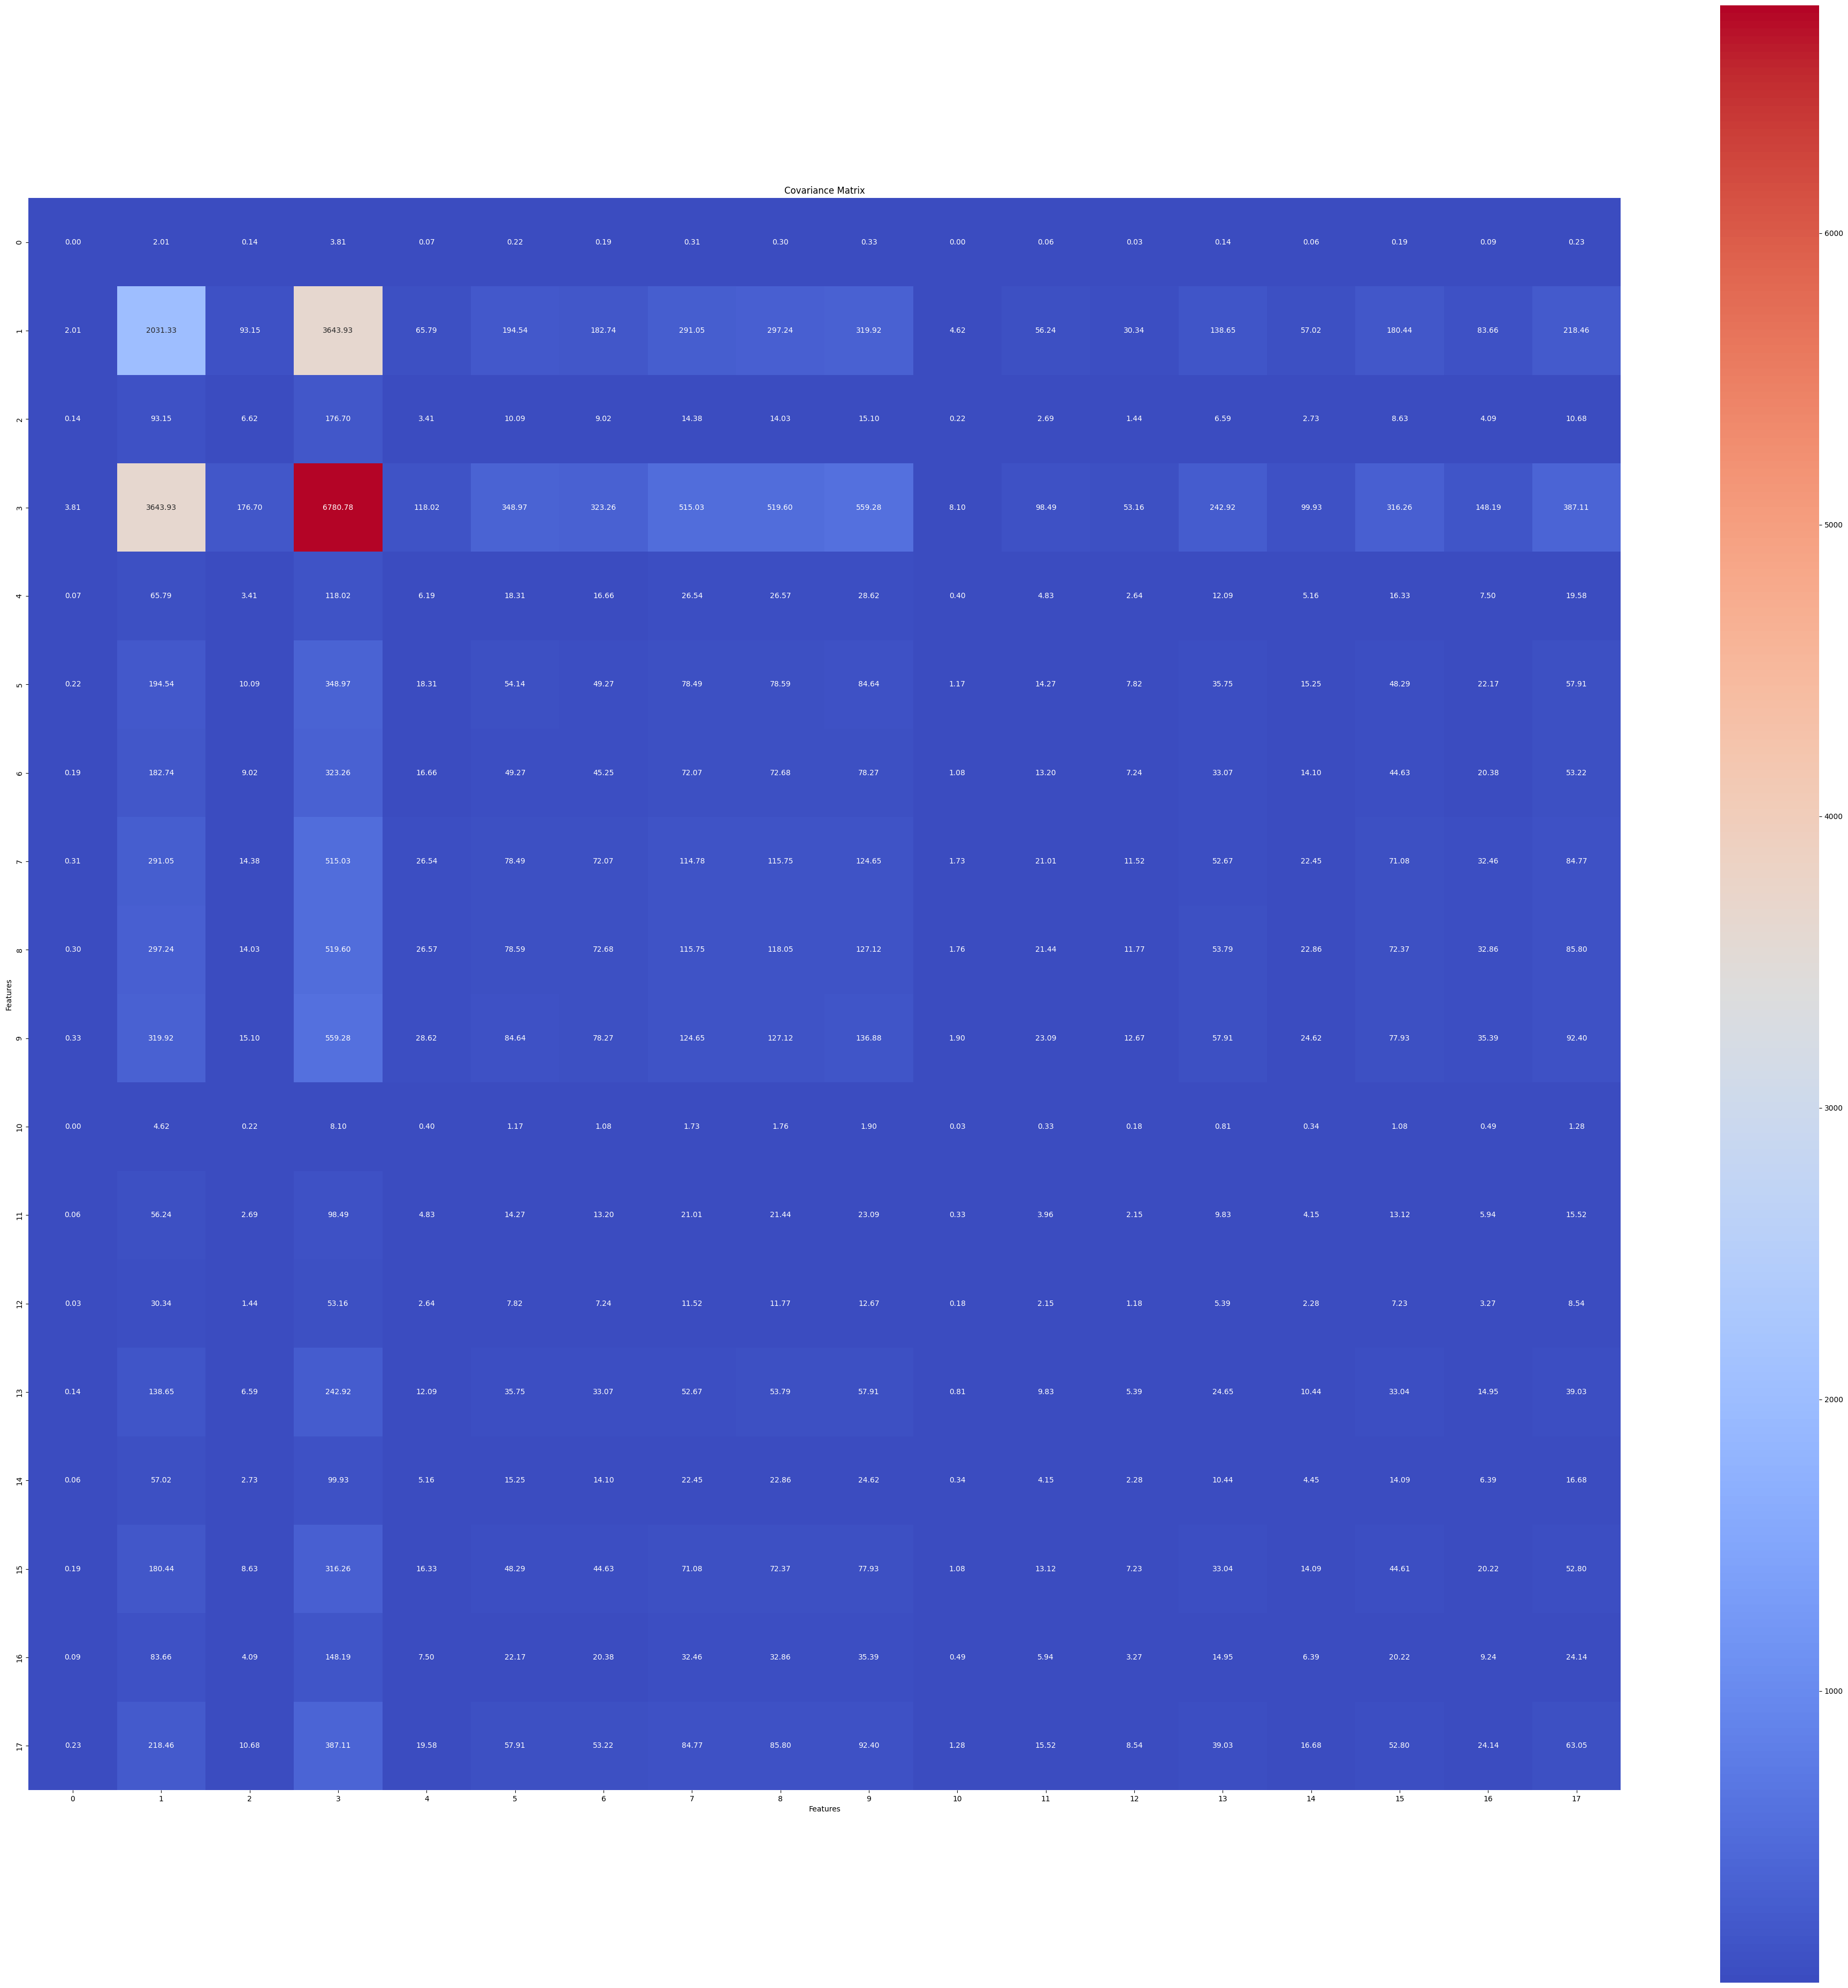

In [243]:
cov_matrix = np.cov(X, rowvar=False) 

plt.figure(figsize=(48, 48))
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Covariance Matrix')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

In [244]:
clf = RandomForestClassifier(n_estimators=1000, random_state=42 , n_jobs=-1)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
Score = cross_val_score(clf, X, y, cv=cv)
print(Score)

KeyboardInterrupt: 